In [1]:
import hashlib
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.metrics import r2_score


import importlib

%load_ext autoreload
%autoreload 2

In [2]:
read_data_path = "experiment/raw-exp-data/exp1/"
write_data_path = "experiment/"

# Loading Data
## Read participant info from questions

In [3]:
questions = pd.read_csv(read_data_path + "questiondata.csv")

In [ ]:
def get_objective_from_string(json_string):
    
    results_dict = json.loads(json_string)
    return results_dict.get("objective", "unknown")
    
def get_trial_type_from_string(json_string):

    results_dict = json.loads(json_string)
    return results_dict.get("trial_type", "unknown")

def get_horizon_from_string(json_string):

    results_dict = json.loads(json_string)
    return results_dict.get("horizon", "unknown")
    
conditions = questions[questions.key == 'condition']
conditions["objective"] = conditions["value"].apply(lambda x: get_objective_from_string(x))
conditions["horizon"] = conditions["value"].apply(lambda x: get_horizon_from_string(x))
conditions["message_type"] = conditions["value"].apply(lambda x: get_trial_type_from_string(x))

participant_objectives = conditions.set_index("workerid")[["message_type", "objective", "horizon"]]

In [57]:
conditions.groupby(["message_type", "objective", "horizon"]).size()

message_type  objective  horizon  
select        ambiguous  ambiguous    101
              belief     ambiguous    100
              utility    ambiguous    100
dtype: int64

In [58]:
conditions["message_type"].value_counts()

select    301
Name: message_type, dtype: int64

In [59]:
# Sanity check other randomizations

if True:
    print("\nLog message counts:")
    print(questions.key.value_counts())
    
    print("\nFull condition messages:")
    print(questions[questions.key == "condition"].value.value_counts())
    
    print("\nTrial data files used:")
    print(questions[questions.key == "trialDataFile"].value.value_counts())

    print("\nFeature randomizations:")
    feature_randomizations = questions[questions.key == "featureRandomization"].value
    feature_randomizations = feature_randomizations.apply(lambda x: json.loads(x))
    feature_randomizations = pd.DataFrame(list(feature_randomizations.values))
    for feature in ["Green", "Red", "Blue", "Spotted", "Solid", "Striped"]:
        print(feature_randomizations[feature].value_counts())


Log message counts:
startTime               330
condition               301
trialDataFile           301
featureRandomization    301
quizAttempt-1           301
quizPassed              285
bonus                   285
quizAttempt-2           138
quizAttempt-3            40
quizFailed               16
Name: key, dtype: int64

Full condition messages:
{"objective":"ambiguous","trial_type":"select","horizon":"ambiguous"}    101
{"objective":"utility","trial_type":"select","horizon":"ambiguous"}      100
{"objective":"belief","trial_type":"select","horizon":"ambiguous"}       100
Name: value, dtype: int64

Trial data files used:
exp1_split3    109
exp1_split2     96
exp1_split1     96
Name: value, dtype: int64

Feature randomizations:
Striped    58
Solid      53
Red        50
Blue       49
Spotted    48
Green      43
Name: Green, dtype: int64
Spotted    60
Green      53
Striped    50
Solid      49
Blue       48
Red        41
Name: Red, dtype: int64
Solid      57
Red        51
Striped    51


## Read in trial data

In [60]:
from datetime import datetime

trials = pd.read_csv(read_data_path + "trialdata.csv")
trials = trials[~trials.workerid.str.contains("debug")]

In [61]:
# Read JSON data into Python objects
trials["data"] = trials.value.apply(lambda x: json.loads(x))

for field in ["rt", "trial_type", "action_context"]:
    trials[field] = trials.data.apply(lambda x: x.get(field))
    
trials.trial_type.value_counts()
trials = trials.set_index("workerid").join(participant_objectives, how="left").reset_index()

In [62]:
print(trials.groupby("objective").workerid.nunique())

objective
ambiguous    101
belief       100
utility      100
Name: workerid, dtype: int64


In [63]:
trials["horizon"] = trials.horizon.apply(lambda x: 1 if x == 'single' else x)
trials["horizon"].value_counts()

ambiguous    15460
Name: horizon, dtype: int64

In [64]:
print("Pre-Quiz Counts")
trials.groupby("message_type").workerid.nunique()

Pre-Quiz Counts


message_type
select    301
Name: workerid, dtype: int64

In [66]:
exit = trials[trials.trial_type == 'survey-text']
exit.groupby("message_type").workerid.nunique()

for question in ["experiment_objective", "participant_strategy", "experiment_confusing", "misc_feedback"]:
    exit[question] = exit.data.apply(lambda x: x["response"][question])
    
for k, g in exit.groupby("objective"):
    print("\n         ====== {} ======\n".format(k))
    
    print("Experiment Objective:\n")
    print(g.experiment_objective.values)

    print("\nParticipant Strategies:\n")
    print(g.participant_strategy.values)

    print("\nAnything Confusing:\n")
    print(g.experiment_confusing.values)

    print("\nMisc Feedback:\n")
    print(g.misc_feedback.values)


         ====== ambiguous ======

Experiment Objective:

['To give information about the mushroom types and which are the tastiest'
 'To tell the person the features of the mushroom'
 'To teach the tourists about mushrooms'
 'help people learn which is the best mushroom'
 'help visitors find the tastiest mushrooms'
 'To teach people about mushrooms and selecting the best one for eating.'
 'To teach visitors about mushrooms' 'T tell people about the fungi'
 'To maximise the tastiness of the recommended mushroom'
 'Help tourists get the most points' 'Help tourists pick mushrooms'
 'Recommend mushroom features for best tasting mushrooms'
 'keep tourists from eating bad mushrooms'
 'To Help advise the best mushroom of 3 each person picked'
 'To try and upsell the best mushroom to pick.'
 'Guiding tourists to pick the tastiest mushroom.'
 'Tell people which mushroom was best'
 'For tourists to pick the tastiest mushrooms'
 'Give information about mushrooms ' 'To choose the best mushrooms'


/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_31062/944433267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit[question] = exit.data.apply(lambda x: x["response"][question])
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_31062/944433267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit[question] = exit.data.apply(lambda x: x["response"][question])
/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_31062/944433267.py:5: SettingWithCopyWarning: 
A value is tryin

# Sanity Checks

##  Instructions
How long do people take in instructions? 

Text(0.5, 0.98, 'Minutes Spent in Instructions')

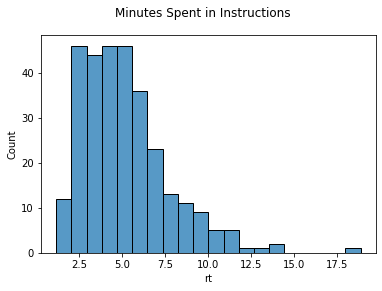

In [67]:
instructions = trials[trials.trial_type == 'instructions']
total_minutes_in_instructions = instructions.groupby("workerid").rt.sum() / 1000 / 60
sns.histplot(total_minutes_in_instructions)
plt.suptitle("Minutes Spent in Instructions")
# total_minutes_in_instructions.describe()

count    301.000000
mean      15.711769
std        6.019468
min        6.375883
25%       10.928733
50%       14.737183
75%       19.422950
max       39.283200
Name: time_elapsed, dtype: float64

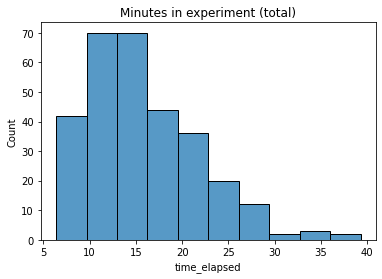

In [68]:
trials["time_elapsed"] = trials.data.apply(lambda x: x.get("time_elapsed"))
minutes_in_experiment = trials.groupby("workerid").time_elapsed.max() / 1000 / 60

sns.histplot(minutes_in_experiment, bins=10)
plt.title("Minutes in experiment (total)")

# print("Median: {:.2f}".format(minutes_in_experiment.median()))
# print("Mean: {:.2f}".format(minutes_in_experiment.mean()))
# print("75th percentile: {:.2f}".format(minutes_in_experiment.quantile(.75)))

minutes_in_experiment.describe()

## Quiz

In [69]:
pass_or_fail = questions[questions.key.isin(["quizPassed", "quizFailed"])]
pass_or_fail.key.value_counts()

quizPassed    285
quizFailed     16
Name: key, dtype: int64

In [70]:
## Additional info on quiz.
quizAttempts = questions[questions.key.str.contains('quizAttempt')]

if False:

    quizAttempts["data"] = quizAttempts.value.apply(lambda x: json.loads(x))
    quizAttempts["correct"] = quizAttempts["data"].apply(lambda x: x["correct"])
    quizAttempts["total"] = quizAttempts["data"].apply(lambda x: x["total"])
    quizAttempts["cum_correct"] = quizAttempts["correct"] + 14 - quizAttempts["total"]
    quizAttempts["passed"] = quizAttempts["data"].apply(lambda x: x["total"] == x["correct"])

    print(quizAttempts.groupby("key").cum_correct.agg(["size", "mean", "std"]))

In [71]:
participant_quiz_results = quizAttempts.groupby("workerid").size()

trials = trials.set_index("workerid").merge(participant_quiz_results.to_frame(name="quiz_attempts"), left_index=True, right_index=True, how="left").reset_index()

# Catch Trials
Do people get these right?  
What is % correct by person?   
By context / question? (are some harder than others?)

In [ ]:
def hash_id(string_to_hash):
    return 'W' + hashlib.md5(string_to_hash.encode()).hexdigest()[:10]

select_trials = trials[trials.trial_type == 'survey-html-form']
catch_trials = select_trials[select_trials['data'].apply(lambda x: bool(x.get('features', 'all') != 'all'))]

catch_trials["belief_model"] = catch_trials.data.apply(lambda x: 1 if x.get("belief") else 0)
catch_trials["response"] = catch_trials.data.apply(lambda x: bool(int(x['response']["utterance"])))
catch_trials["catch_trial_correct"] = catch_trials["belief_model"] == catch_trials["response"]

catch_trials["feature"] = catch_trials.data.apply(lambda x: x.get("features")[0])
catch_trials["feature_value"] = catch_trials.data.apply(lambda x: x.get("values")[0])

catch_trials["action_context"] = catch_trials.data.apply(lambda x: str([x.get("action_context")[0]]))
catch_trials["context_hash"] = catch_trials.action_context.apply(hash_id)

In [74]:
print("{} trials, {} unique workers.".format(len(catch_trials), catch_trials.workerid.nunique()))

2280 trials, 285 unique workers.


In [75]:
shared_trials = catch_trials#[catch_trials.context_hash.isin(shared_catch_trials.context_hash.unique())]

Text(0, 0.5, 'Fraction of participants')

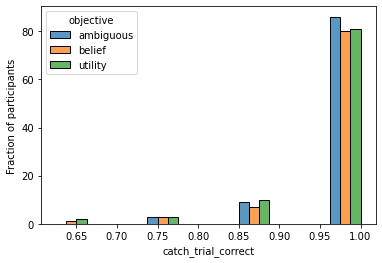

In [22]:
participant_catch_results = shared_trials[["catch_trial_correct", "objective", "workerid", "message_type"]].groupby(["workerid", "objective", "message_type"]).mean().reset_index()
participant_catch_results["passed_catch_trial"] = participant_catch_results.catch_trial_correct > .75

sns.histplot(participant_catch_results, x="catch_trial_correct", hue="objective", multiple="dodge")
plt.ylabel("Fraction of participants")

In [23]:
condition_catch_results = participant_catch_results.groupby("message_type")["passed_catch_trial"].agg([np.sum, np.size]).reset_index() 
condition_catch_results["pct_passed"] = condition_catch_results["sum"] / condition_catch_results["size"]
condition_catch_results["pct_passed"] = condition_catch_results["sum"] / condition_catch_results["size"]
print(condition_catch_results[["message_type", "sum"]])

  message_type  sum
0       select  273


In [24]:
# Join catch results into main dataframe to simplify analysis
joined_trials = trials.set_index("workerid").join(participant_catch_results[["passed_catch_trial", "catch_trial_correct", "workerid"]].set_index('workerid')).reset_index()
joined_trials.passed_catch_trial = joined_trials.passed_catch_trial.astype(bool)
joined_trials["no_catch_data"] = joined_trials.passed_catch_trial.isnull()

In [25]:
print("{} unique workers before join, {} after.".format(trials.workerid.nunique(), joined_trials.workerid.nunique()))

joined_trials.groupby(["objective", "horizon", "passed_catch_trial"]).workerid.nunique()

301 unique workers before join, 301 after.


objective  horizon    passed_catch_trial
ambiguous  ambiguous  False                  3
                      True                  98
belief     ambiguous  False                  4
                      True                  96
utility    ambiguous  False                  5
                      True                  95
Name: workerid, dtype: int64

In [26]:
joined_trials.passed_catch_trial.value_counts()

True     14804
False      656
Name: passed_catch_trial, dtype: int64

In [27]:
joined_trials.groupby("passed_catch_trial").workerid.nunique()

passed_catch_trial
False     12
True     289
Name: workerid, dtype: int64

## Drop participants that did not pass

In [28]:
joined_trials = joined_trials[joined_trials.passed_catch_trial]

# Exp 1 - Choosing Utterances

## Visualize Responses

In [29]:
select_trials = joined_trials[joined_trials.trial_type == 'survey-html-form']

exp1_trials = select_trials[select_trials["data"].apply(lambda x: x.get("features", "all") == "all")]

len(exp1_trials)

7644

In [30]:
exp1_trials.objective.value_counts()

ambiguous    2660
utility      2548
belief       2436
Name: objective, dtype: int64

In [31]:
exp1_trials.groupby(["objective", "passed_catch_trial"]).workerid.nunique()

objective  passed_catch_trial
ambiguous  True                  95
belief     True                  87
utility    True                  91
Name: workerid, dtype: int64

In [76]:
exp1_trials["feature"] = exp1_trials.data.apply(lambda x: x["response"]["feature"])
exp1_trials["feature_value"] = exp1_trials.data.apply(lambda x: int(x["response"]["feature_value"]))

In [77]:
SB_REWARDS = {"Green": 2, "Red": 0,  "Blue": -2, "Spotted": 1, "Solid": 0, "Striped": -1}

exp1_trials["truthful"] = exp1_trials.apply(lambda x: SB_REWARDS[x['feature']] == x['feature_value'], axis=1)
pct_by_condition = exp1_trials.groupby('objective').truthful.value_counts() / exp1_trials.groupby('objective').size()

pct_by_condition = pct_by_condition.reset_index()

In [78]:
pct_by_condition

,objective,truthful,0
0,ambiguous,True,0.848120
1,ambiguous,False,0.151880
2,belief,True,0.951970
3,belief,False,0.048030
4,utility,True,0.670722
5,utility,False,0.329278


## ANOVA to confirm difference in truth-telling by condition

In [82]:
melted = pd.melt(exp1_trials, id_vars=['workerid', 'objective'], value_vars=['truthful'])
res = []
for (k1, k2), g in melted.groupby(['workerid', 'objective']):
    res.append({"workerid": k1, "objective": k2, "truthful_pct": len(g[g.value])/ len(g)})
res = pd.DataFrame(res)

/var/folders/gv/42lb0z1j4dxf3wsk74nrxwx80000gn/T/ipykernel_31062/275443705.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted = pd.melt(exp1_trials, id_vars=['workerid', 'objective'], value_vars=['truthful'])


In [83]:
from scipy.stats import f_oneway

ambiguous = res[res.objective=='ambiguous'].truthful_pct
belief = res[res.objective=='belief'].truthful_pct
utility = res[res.objective=='utility'].truthful_pct

f_oneway(ambiguous, belief, utility)

F_onewayResult(statistic=49.40139618810778, pvalue=5.210640075178156e-19)

In [84]:
def heatmap_messages(to_plot_messages, title="", vmax=None, hide_axes=True, normalize=True, cmap=None, cbar=True, ax=None):
        
    percent_of_messages = to_plot_messages.groupby(["feature", "feature_value"]).size().reset_index()
    if normalize:
        percent_of_messages[0] = percent_of_messages[0] / len(to_plot_messages)

    for feat, val in SB_REWARDS.items():
        message = percent_of_messages[(percent_of_messages.feature == feat) & (percent_of_messages.feature_value == val)]
        if len(message) != 1:
            percent_of_messages = pd.concat([percent_of_messages, 
                                             pd.DataFrame.from_records([{"feature": feat, "feature_value": val}])], axis=0)

    percent_of_messages['label'] = percent_of_messages.apply(lambda x: "X" if SB_REWARDS[x['feature']] == x['feature_value'] else "", axis=1)
    labels = percent_of_messages.pivot("feature_value", "feature", "label")
    labels = labels.fillna("")
    
    message_table = percent_of_messages.pivot("feature_value", "feature", 0)

    features_in_descending_order = ["Green", "Spotted", "Red", "Solid", "Striped", "Blue"]
    message_table = message_table.reindex(features_in_descending_order, axis=1).fillna(0)
    labels = labels.reindex(features_in_descending_order, axis=1)

    if vmax is None:
        vmax = percent_of_messages[0].max()
        
    ax = sns.heatmap(message_table, annot=labels,annot_kws={"fontsize":30}, fmt='', cmap=cmap, vmax=vmax, 
                     linewidths=1, ax=ax, cbar=cbar, linecolor='darkgray')
    ax.invert_yaxis()
    
    # use matplotlib.colorbar.Colorbar object
    if cbar:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=30)
        
    if hide_axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

In [85]:
exp1_trials["str_action_context"] = exp1_trials.action_context.apply(lambda x: json.dumps(x[0]))

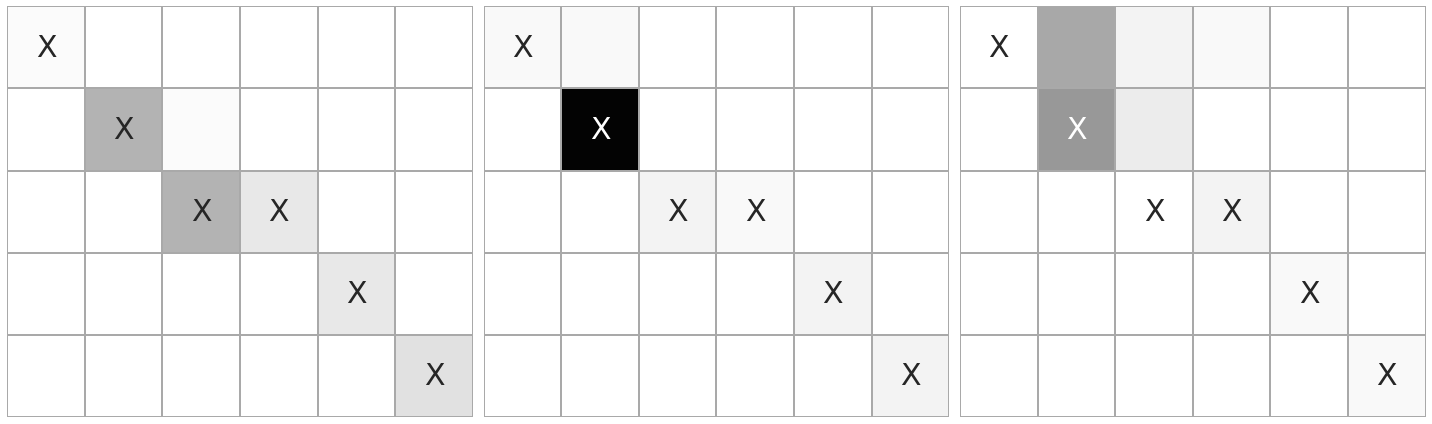

In [86]:
context = '[{"color": "Blue", "texture": "Striped"}, {"color": "Red", "texture": "Spotted"}, {"color": "Red", "texture": "Solid"}]'

demo_context = exp1_trials[exp1_trials.str_action_context == context]

conditions = ['belief', 'ambiguous', 'utility']
                                                               
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, ax in enumerate(axs.flat): 

    cbar = (i == 2)
    heatmap_messages(demo_context[demo_context.objective == conditions[i]], cmap='Greys', vmax=.7, ax=ax, cbar=False)

plt.tight_layout()
plt.savefig('figures/empirical_heatmaps.pdf')

# demo_condition = demo_context[demo_context.objective == condition]

# title = "{}: {} participants.".format(condition, len(demo_condition))

# heatmap_messages(demo_condition, title="", hide_axes=True, normalize=True, cmap='Greys')

# Posterior Predictive plots

In [87]:
for_posterior = exp1_trials[exp1_trials.objective == 'ambiguous']

for_posterior = for_posterior.groupby(['feature', 'feature_value', 'str_action_context']).size().reset_index()
for_posterior = for_posterior.rename({0: "responses", 'feature_value': 'value', 'str_action_context': 'action_context'}, axis=1)

normalized_by_context = []
for k, g in for_posterior.groupby('action_context'):
    g["Empirical Probability"] = g["responses"] / g["responses"].sum()
    normalized_by_context.append(g)

normalized = pd.concat(normalized_by_context)
# normalized = normalized.set_index()

In [88]:
try:
    posterior_pred = pd.read_json("exp1_posterior_predictive_mle.json")
except FileNotFoundError:
    print("Error: you must run the simulation notebook to produce MLE predictions first.")
    
posterior_pred = posterior_pred.rename({'MLE-unbiased-combined_prob': "Combined", 
                                        'MLE-unbiased-combined-valence_prob': "Combined-Valence", 
                                        'MLE-unbiased-belief-only_prob': 'Belief Only', 
                                        'MLE-unbiased-action-only_prob': 'Action Only',
                                       'MLE-action-bias-combined_prob': 'Action Biased',
                                       'MLE-belief-bias-combined_prob': 'Belief Biased'}, axis=1)

posterior_pred = pd.merge(posterior_pred, normalized, how='left', 
                          left_on=["action_context", "feature", "value"],
                          right_on=["action_context", "feature", "value"]).reset_index()

posterior_pred = posterior_pred.fillna(0)

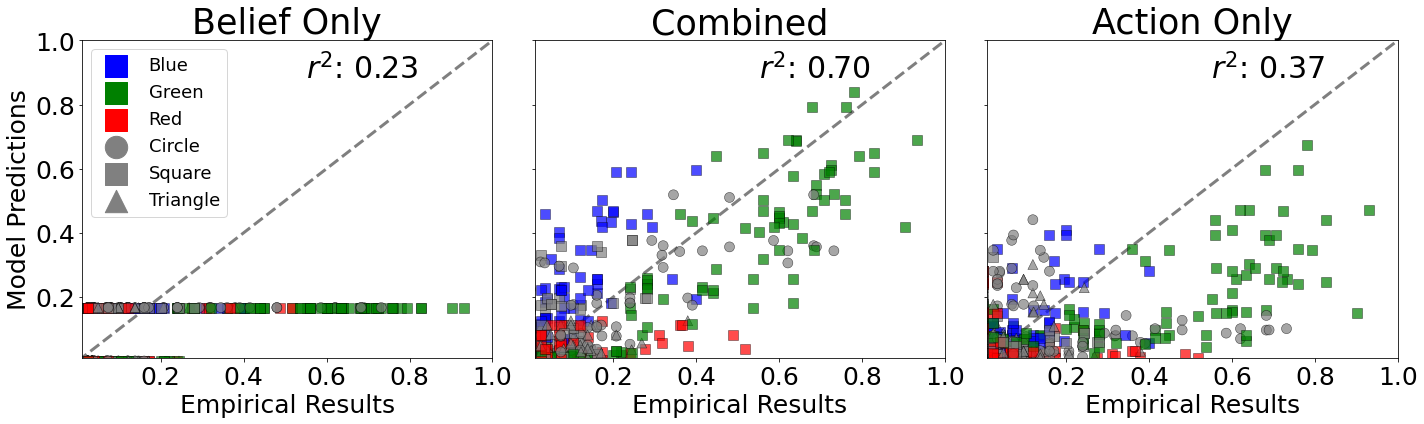

In [90]:
models = ['Belief Only', 'Combined', 'Action Only']
to_plot = posterior_pred

rename_dict = {"Blue": "Blue",
               "Green": "Green",
               "Red": "Red",
               "Spotted": "Circle",
               "Striped": "Square",
               "Solid": "Triangle"}

posterior_pred['feature_to_plot'] = posterior_pred.feature.apply(lambda x: rename_dict[x])
                                                                 
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for i, ax in enumerate(axs.flat): 

    ax.plot([0, 1], [0, 1], c='k', linestyle='--', alpha=.5, linewidth=3, zorder=0)

    g = sns.scatterplot(data=to_plot, x='Empirical Probability', y=models[i], 
                        hue='feature_to_plot', palette=['b', 'g', 'r', 'gray', 'gray','gray'],
                        style='feature_to_plot', markers=['s', 's', 's', 'o', 's','^'], 
                        alpha=.7, s=100,  linewidth=.5, edgecolor='k', ax=ax)

    ax.set_xlabel("Empirical Results", fontsize=25)
    ax.set_ylabel("Model Predictions", fontsize=25)
    ax.set_title(models[i], fontsize=35)
    ax.tick_params(labelsize=25)

    ax.text(.55, .88, "$r^2$: {:.2f}".format(r2_score(posterior_pred["Empirical Probability"], posterior_pred[models[i]])), 
             fontsize=30);
    
    if i == 0:
        lgnd = ax.legend(loc="upper left", scatterpoints=1, fontsize=18)
        for handle in lgnd.legendHandles:
            handle.set_sizes([500.0])
    else:
        ax.get_legend().remove()

    ax.set_xlim(1e-2, 1)
    ax.set_ylim(1e-2, 1)

plt.tight_layout()
plt.savefig('figures/exp1-variance-explained.pdf', bbox_inches='tight')

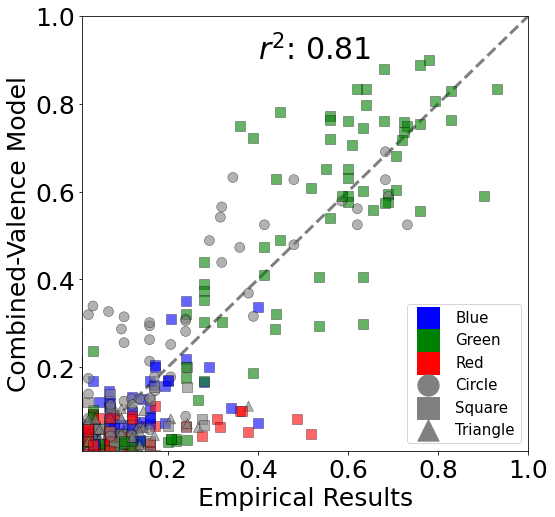

In [91]:
model_to_plot = 'Combined-Valence' # Combined, Belief Only, Utility Only, beta-five-combined_prob

to_plot = posterior_pred

plt.figure(figsize=(8, 8))

rename_dict = {"Blue": "Blue",
               "Green": "Green",
               "Red": "Red",
               "Spotted": "Circle",
               "Striped": "Square",
               "Solid": "Triangle"}

to_plot['feature_to_plot'] = to_plot.feature.apply(lambda x: rename_dict[x])

g = sns.scatterplot(data=to_plot, x='Empirical Probability', y=model_to_plot, 
                hue='feature_to_plot', palette=['b', 'g', 'r', 'gray', 'gray','gray'],
               style='feature_to_plot', markers=['s', 's', 's', 'o', 's','^'],
               alpha=.6, s=100,  linewidth=.5, edgecolor='k')

plt.xlabel("Empirical Results", fontsize=25)
plt.ylabel("{} Model".format(model_to_plot), fontsize=25)
plt.gca().tick_params(labelsize=25)

plt.plot([0, 1], [0, 1], c='k', linestyle='--', alpha=.5, linewidth=3, zorder=0)

plt.text(.4, .9, "$r^2$: {:.2f}".format(r2_score(posterior_pred["Empirical Probability"], posterior_pred[model_to_plot])), 
         fontsize=30);

lgnd = plt.gca().legend(loc="lower right", scatterpoints=1, fontsize=15)
for handle in lgnd.legendHandles:
    handle.set_sizes([450.0])

plt.xlim(1e-2, 1)
plt.ylim(1e-2, 1)

plt.savefig("figures/combined-valence-variance-explained.pdf", bbox_inches='tight')
plt.show()

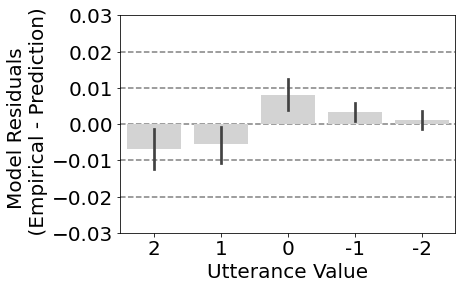

In [92]:
posterior_pred['signed_error'] = posterior_pred["Empirical Probability"] - posterior_pred['Combined-Valence']
posterior_pred['abs_error'] = abs(posterior_pred['signed_error'])

ax1 = sns.barplot(data=posterior_pred, x="value", y="signed_error", color='lightgray',
           order=[2, 1, 0, -1, -2])


ys = [-.03, -.02, -.01, 0, .01, .02, .03]
for y in ys[1:-1]:
    ax1.axhline(y, alpha=.5, linestyle='--', c='k', zorder=0)

ax1.set_ylim(-.03, .03)
ax1.tick_params(labelsize=20)
    
ax1.set_yticks(ys)
ax1.set_ylabel("Model Residuals \n (Empirical - Prediction)", fontsize=20)
ax1.set_xlabel("Utterance Value", fontsize=20)

plt.savefig('figures/appendix/model_residuals_by_value_valence_fit.pdf', bbox_inches='tight')

plt.show()

## Export Data for WebPPL

In [93]:
def extract_single_action_trials(trial, filter_on_catch_trials):
    
    jspsych_log_data = trial.get("data", {})
    action_context = jspsych_log_data.get("action_context")
    
    if not action_context:
        return None
    
    if len(action_context) > 1:
        print("{} actions found, can't process.".format(len(action_context)))
        return None
    
    if filter_on_catch_trials:
        if not trial["passed_catch_trial"]:
            return None
    
    return {"action_context": action_context[0],
            "workerid": trial["workerid"],
            "objective": trial["objective"],
            "response": {"feature": trial["feature"], "feature_value": trial["feature_value"]}}

In [94]:
single_action_trial_results = exp1_trials.apply(lambda x: extract_single_action_trials(x, filter_on_catch_trials=True), axis=1)
valid_trial_data = list(single_action_trial_results.dropna().values)

In [95]:
print("Processed {} workers, returned {}.".format(
    exp1_trials.workerid.nunique(), 
    pd.DataFrame.from_records(single_action_trial_results.dropna().values).workerid.nunique()))

Processed 273 workers, returned 273.


In [96]:
# Write all the data out together
with open(write_data_path + 'webppl-input/select/ALL-exp1.json', 'w') as outfile:
    json.dump(valid_trial_data, outfile)

# Split data by condition and write it out
for condition in ['belief', 'utility', 'ambiguous']:
    
    to_output = [x for x in valid_trial_data if x.get("objective") == condition]
    with open(write_data_path + 'webppl-input/select/{}-exp1.json'.format(condition), 'w') as outfile:
        json.dump(to_output, outfile)

# Split data by worker and write it out
workers = list(set([v["workerid"] for v in valid_trial_data]))
for workerid in workers:
    
    to_output = [x for x in valid_trial_data if x.get("workerid") == workerid]

    with open(write_data_path + 'webppl-input/select/participants/{}.json'.format(workerid), 'w') as outfile:
        json.dump(to_output, outfile)

## Read in WebPPL outputs

In [97]:
participant_mles = pd.read_json(open("experiment/webppl-exp1/participant_maximum_likelihood_params.json")).set_index("workerid")

In [98]:
participant_mles["truthWeight"] = 1 - participant_mles["utilityWeight"]
joined = exp1_trials.set_index("workerid").join(participant_mles, how='inner').reset_index()
print("Joined in {} results.".format(joined.workerid.nunique()))

by_condition = joined.groupby("workerid")[["workerid", "passed_catch_trial", "utilityWeight", "truthWeight", "objective", "alphaS"]].sample(1).dropna()

Joined in 273 results.


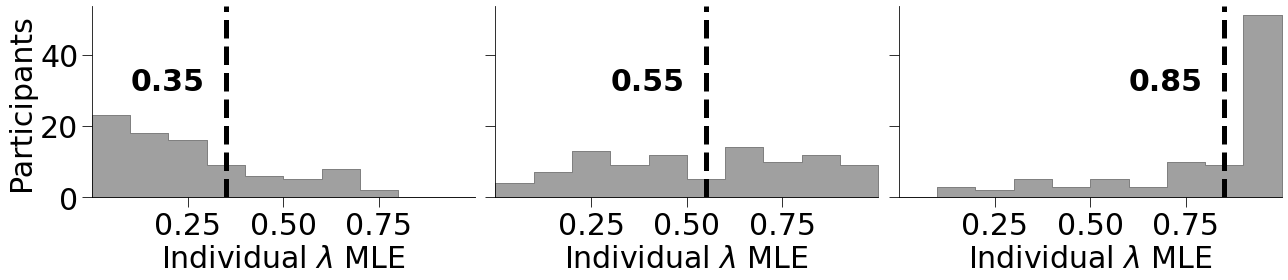

In [99]:
to_plot = by_condition

mles = {
    "utility": 0.85,
    "ambiguous": 0.55, 
    "belief": 0.35
}

label_locs = [.1, .30, .60]
title_order = ["Belief Bias", "Unbiased", "Action Bias"]

col_order = ['belief', 'ambiguous', 'utility']
facet = sns.displot(to_plot, col="objective", col_order=col_order, x="utilityWeight", element="step",
                   height=4, aspect=1.5, color='gray')

for i, ax in enumerate(facet.axes[0]):

    ax.set_title("")
#     ax.set_title(title_order[i], fontsize=45)

    ax.set_xlim(0, 1)
    ax.set_xticks([.25, .5, .75])
    ax.tick_params(labelsize=30, length=10)

    mle = mles[col_order[i]]
    ax.axvline(mle, linewidth=5, linestyle='--', c='k')
    ax.text(label_locs[i], 30, "{}".format(mles[col_order[i]]), 
            fontdict={"size": 30, "weight": 'bold'})
    
    ax.set_xlabel("Individual $\lambda$ MLE", fontsize=30)

    if i == 0:
        ax.set_ylabel("Participants", fontsize=30) 

facet.tight_layout()
        
plt.savefig("figures/exp1_mle_estimates.pdf")
plt.show()


## Response Times

In [100]:
joined['rt_seconds'] = joined.data.apply(lambda x: x["rt"] / 1000)
joined['log_rt_seconds'] = np.log(joined.rt_seconds)
joined[['workerid', 'rt_seconds', 'utilityWeight', 'truthful', 'log_rt_seconds']].to_csv("response_times_for_r.csv")

In [52]:
import scipy.stats

truthful_rts = joined[joined.truthful].rt_seconds
false_rts = joined[~joined.truthful].rt_seconds
scipy.stats.ttest_ind(np.log(truthful_rts), np.log(false_rts))

Ttest_indResult(statistic=-10.76632981148753, pvalue=7.728016948898333e-27)

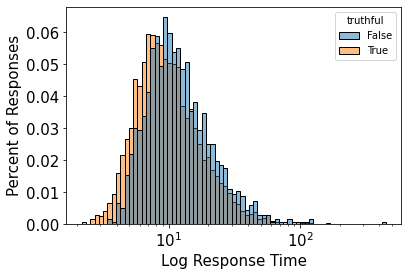

In [101]:
ax = sns.histplot(data=joined, hue='truthful', x='rt_seconds', stat='probability', common_norm=False, log_scale=True)
plt.gca().tick_params(labelsize=15)
plt.xlabel("Log Response Time", fontsize=15)
plt.ylabel("Percent of Responses", fontsize=15)

plt.savefig('figures/response_times_by_truthfulness.pdf', bbox_inches='tight')
